In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from torchvision.transforms import ToTensor
import timm
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score, recall_score

In [ ]:
torch.cuda.is_available()

True

### N_freeze = 0, ReduceLROnPlateau scheduler, no additional layers

Found 7 classes: ['akiec_augmentations_full_res', 'bcc_augmentations_full_res', 'bkl_augmentations_full_res', 'df_augmentations_full_res', 'mel_augmentations_full_res', 'nv_augmentations_full_res', 'vasc_augmentations_full_res']


Epoch 1/15 [Val]: 100%|██████████| 2077/2077 [01:13<00:00, 28.26it/s, loss=0.5867]


Epoch 1/15 completed - Train Loss: 0.6844, Val Loss: 0.3384, Val Accuracy: 88.22%, Val Precision: 0.8268, Val Recall: 0.8876

Best model saved at epoch 1 with val loss: 0.3384


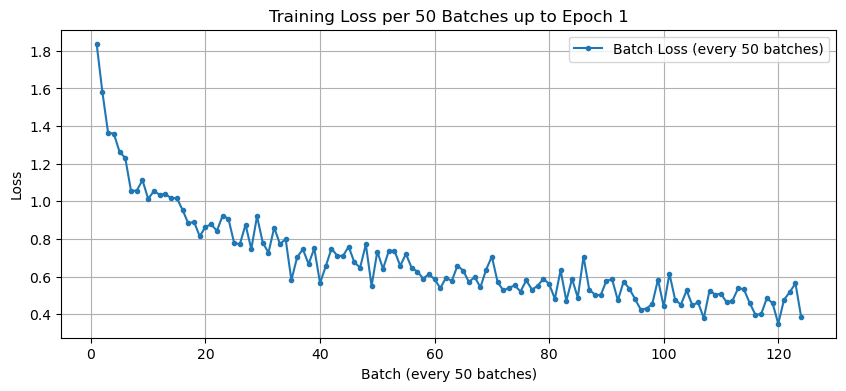

Epoch 2/15 [Val]: 100%|██████████| 2077/2077 [01:13<00:00, 28.23it/s, loss=0.1399]


Epoch 2/15 completed - Train Loss: 0.2788, Val Loss: 0.2035, Val Accuracy: 92.79%, Val Precision: 0.8885, Val Recall: 0.9346

Best model saved at epoch 2 with val loss: 0.2035


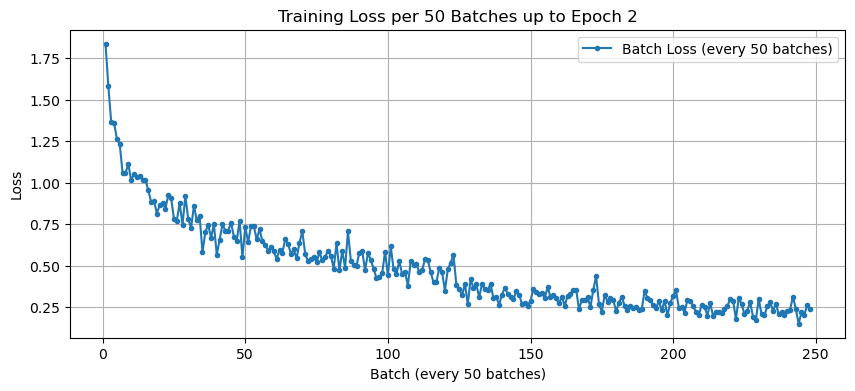

Epoch 3/15 [Val]: 100%|██████████| 2077/2077 [01:13<00:00, 28.13it/s, loss=0.5742]


Epoch 3/15 completed - Train Loss: 0.1202, Val Loss: 0.1215, Val Accuracy: 95.82%, Val Precision: 0.9364, Val Recall: 0.9635

Best model saved at epoch 3 with val loss: 0.1215


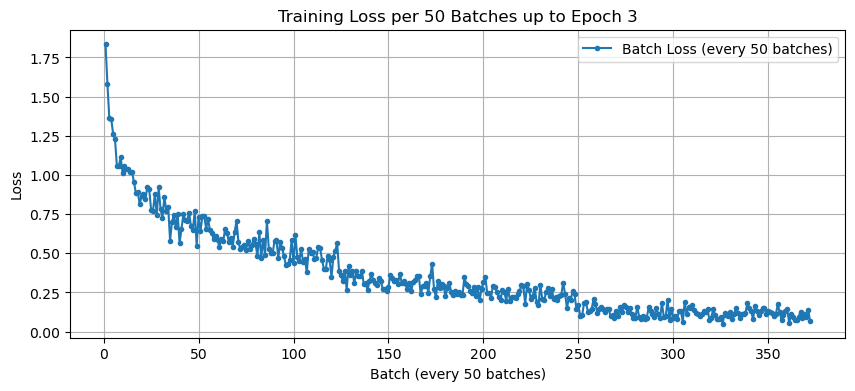

Epoch 4/15 [Val]: 100%|██████████| 2077/2077 [01:13<00:00, 28.11it/s, loss=0.0103]

Epoch 4/15 completed - Train Loss: 0.0617, Val Loss: 0.1393, Val Accuracy: 95.16%, Val Precision: 0.9085, Val Recall: 0.9573



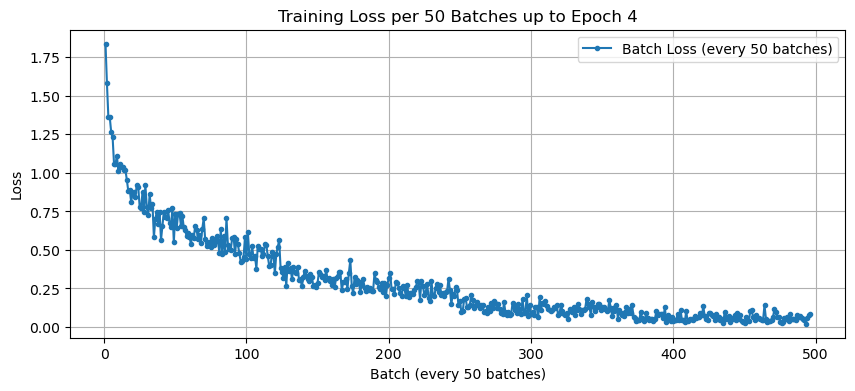

Epoch 5/15 [Val]: 100%|██████████| 2077/2077 [01:14<00:00, 28.03it/s, loss=0.3050]


Epoch 5/15 completed - Train Loss: 0.0430, Val Loss: 0.1180, Val Accuracy: 96.12%, Val Precision: 0.9382, Val Recall: 0.9685

Best model saved at epoch 5 with val loss: 0.1180


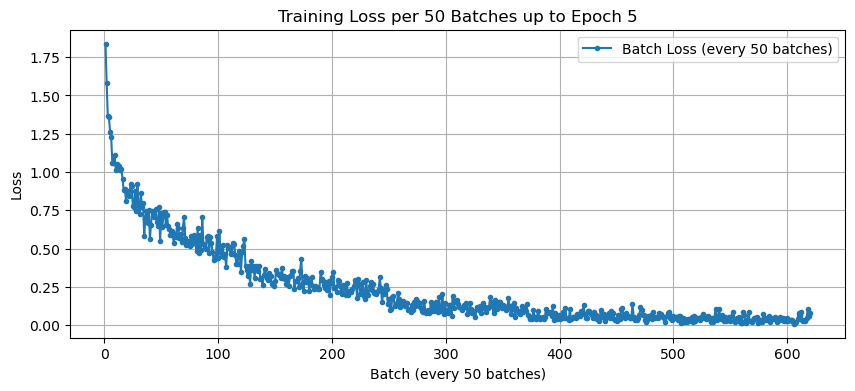

Epoch 6/15 [Val]: 100%|██████████| 2077/2077 [01:14<00:00, 28.04it/s, loss=0.3009]


Epoch 6/15 completed - Train Loss: 0.0316, Val Loss: 0.1176, Val Accuracy: 96.30%, Val Precision: 0.9440, Val Recall: 0.9702

Best model saved at epoch 6 with val loss: 0.1176


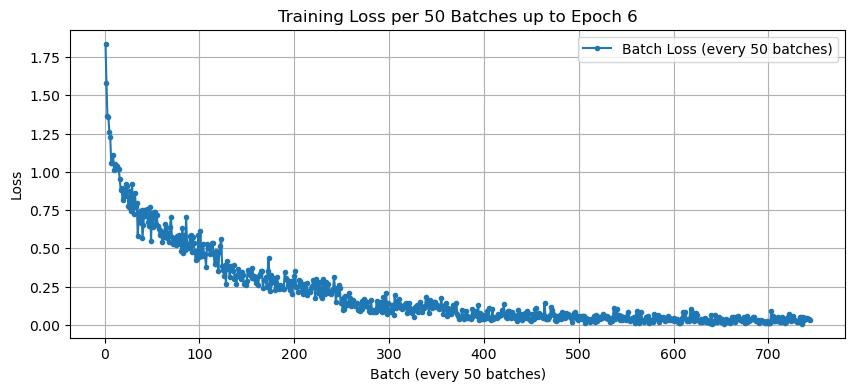

Epoch 7/15 [Val]: 100%|██████████| 2077/2077 [01:13<00:00, 28.27it/s, loss=0.1170]


Epoch 7/15 completed - Train Loss: 0.0250, Val Loss: 0.0729, Val Accuracy: 97.57%, Val Precision: 0.9729, Val Recall: 0.9802

Best model saved at epoch 7 with val loss: 0.0729


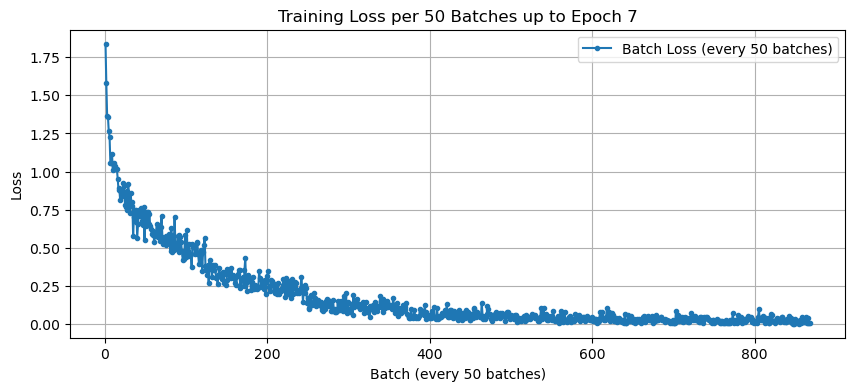

Epoch 8/15 [Val]: 100%|██████████| 2077/2077 [01:14<00:00, 27.94it/s, loss=0.1230]

Epoch 8/15 completed - Train Loss: 0.0227, Val Loss: 0.0903, Val Accuracy: 96.93%, Val Precision: 0.9530, Val Recall: 0.9736



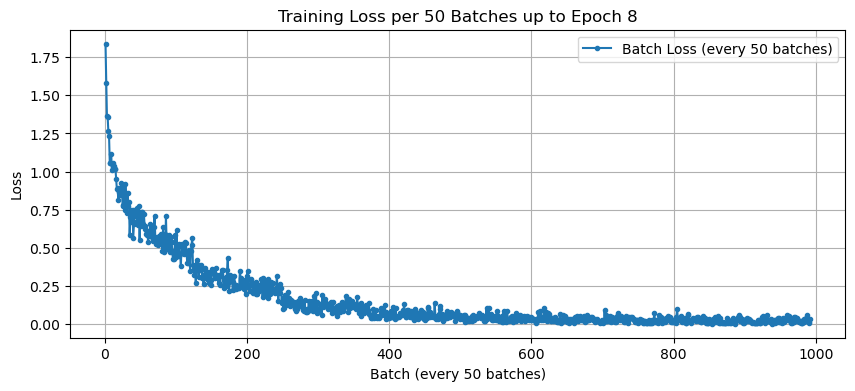

Epoch 9/15 [Val]: 100%|██████████| 2077/2077 [01:14<00:00, 27.97it/s, loss=0.0844]

Epoch 9/15 completed - Train Loss: 0.0193, Val Loss: 0.0892, Val Accuracy: 97.39%, Val Precision: 0.9694, Val Recall: 0.9690

Early stopping triggered after 9 epochs.


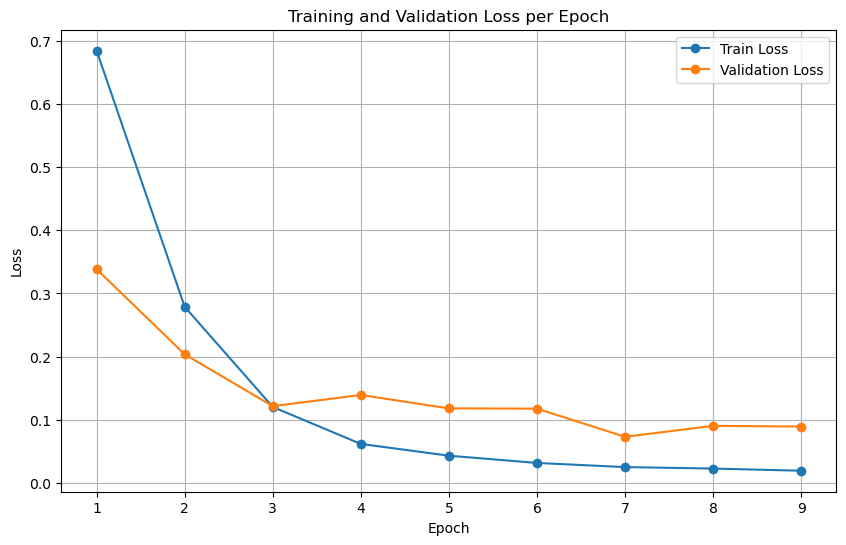

In [ ]:
# Hyperparams:
lr = 1e-5
train_ratio = 0.75
batch_size = 4
epochs = 15
early_stop_patience = 2
N_freeze = 0 # max value 6 because totally 7 blocks
best_model_path = 'best_model_n_0_plwateau.pt'

data_dir = "480_white/"

# Define transforms: convert to tensor and normalize as per ImageNet stats
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(root=data_dir, transform=transform)
num_classes = len(dataset.classes)
print(f"Found {num_classes} classes: {dataset.classes}")

train_size = int(train_ratio * len(dataset))
val_size = len(dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

model = timm.create_model('tf_efficientnetv2_l.in21k_ft_in1k', pretrained=True)

# Adding new head:
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Linear(in_features, num_classes)
)

if N_freeze > 0:
    for param in model.conv_stem.parameters():
        param.requires_grad = False
    for param in model.bn1.parameters():
        param.requires_grad = False
    for idx, block in enumerate(model.blocks.children()):
        if idx < N_freeze:
            for param in block.parameters():
                param.requires_grad = False
        else:
            break

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

# Trying different schedulers:

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=1, factor=0.5)

train_losses, val_losses = [], []
batch_losses = []

best_val_loss = float('inf')
no_improve_epochs = 0

for epoch in range(1, epochs + 1):
    model.train()
    running_loss = 0.0
    batch_loss = 0.0
    epoch_batch_losses = []
    train_bar = tqdm(enumerate(train_loader, 1), total=len(train_loader), desc=f"Epoch {epoch}/{epochs} [Train]")

    for batch_idx, (images, labels) in train_bar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        batch_loss += loss.item()

        if batch_idx % 50 == 0:
            avg_batch_loss = batch_loss / 50
            epoch_batch_losses.append(avg_batch_loss)
            batch_loss = 0.0

        train_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)
    batch_losses.extend(epoch_batch_losses)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_labels, all_preds = [], []

    val_bar = tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Val]")
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

            val_bar.set_postfix(loss=f"{loss.item():.4f}")

    epoch_val_loss = val_loss / len(val_loader.dataset)
    val_accuracy = 100 * correct / total
    val_losses.append(epoch_val_loss)

    val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Epoch {epoch}/{epochs} completed - "
          f"Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f}, "
          f"Val Accuracy: {val_accuracy:.2f}%, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}\n")

    scheduler.step(epoch_val_loss)

    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        no_improve_epochs = 0
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch} with val loss: {best_val_loss:.4f}")
    else:
        no_improve_epochs += 1
        if no_improve_epochs >= early_stop_patience:
            print(f"Early stopping triggered after {epoch} epochs.")
            break

    plt.figure(figsize=(10, 4))
    plt.plot(range(1, len(batch_losses) + 1), batch_losses, label='Batch Loss (every 50 batches)', marker='.')
    plt.xlabel('Batch (every 50 batches)')
    plt.ylabel('Loss')
    plt.title(f'Training Loss per 50 Batches up to Epoch {epoch}')
    plt.legend()
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()